In [2]:
from jax_circuits import*
from topology import *
from penalty import *
from cp_utils import *
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from qiskit import transpile
from qiskit.quantum_info import Operator
import pickle

Initially the goal was to try and use CP-gates to learn optimal CZ placements. This seems to be very difficult because of the local minimums. Whether the minimums are related to CP-penaly function or to 1q gate angles is not clear. Several directions can be interesting besides looking for truly optimal CZ decompositions:
- Do CP circuits learn themselves better, compared to CZ circuits at the same gate count?
- Compare non-optimal CZ decompositions with some other transpiling implementation, such as Qiskit.
- Be OK with arbitrary angles in CP gates. Does this perform better? Can this improve on the number of CZ gates in qiskit?
- How is sum of CP angles distributed? Say, if you need 20 CNOT in the circuit, does it mean that CP angles must sum to ~20 *pi , or one can do better?


# Qiskit decompositions

## Toffoli 3 chain

In [9]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)

best_count = 100
for s in range(50):
    qc_trans = transpile(qc, basis_gates=['cz', 'u'], coupling_map=[[0,1],[1,0],[1,2],[2,1]], optimization_level=3, seed_transpiler=s)
    count = qc_trans.qasm().count('\ncz')
    if count < best_count:
        best_count=count


print(best_count)

8


## Toffoli 4 chain

In [14]:
%time
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)

best_count = 100
best_s = 0
for s in range(1000):
    qc_trans = transpile(qc, basis_gates=['cz', 'u'], coupling_map=[[0,1],[1,0],[1,2],[2,1],[2,3],[3,2]], optimization_level=3, seed_transpiler=s)
    count = qc_trans.qasm().count('\ncz')
    if count < best_count:
        best_count=count
        best_s = s


print(best_count, best_s)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs
21


## Toffoli 5 connected

Best decomposition known to qiskit seems to be 36 gates long.

## Toffoli 5 chain

In [8]:
qc = QuantumCircuit(5)
qc.mct([0, 1, 2, 3], 4)

best_count = 63
best_s = 2500 #approx
coupling_map=[[0,1],[1,0],[1,2],[2,1],[2,3],[3,2],[3,4],[4,3]]
for s in range(6000, 8000):
    qc_trans = transpile(qc, basis_gates=['cz', 'u'], coupling_map=coupling_map, optimization_level=3, seed_transpiler=s)
    count = qc_trans.qasm().count('\ncz')
    if count <= best_count:
        best_s = s
        best_count=count

print(best_count, best_s)

63 7582


In [12]:
qc = QuantumCircuit(6)
qc.mct([0, 1, 2, 3], 4, ancilla_qubits=[5])

best_count = 63
best_s = 2500 #approx
coupling_map=[[0,1],[1,0],[1,2],[2,1],[2,3],[3,2],[3,4],[4,3],[4,5],[5,4]]
for s in range(0, 100):
    qc_trans = transpile(qc, basis_gates=['cz', 'u'], coupling_map=coupling_map, optimization_level=3, seed_transpiler=s)
    count = qc_trans.qasm().count('\ncz')
    if count <= best_count:
        best_s = s
        best_count=count

print(best_count, best_s)

63 2500


## Toffoli 5 star

In [5]:
qc = QuantumCircuit(5)
qc.mct([0, 1, 2, 3], 4)

best_count = 63
best_s = 98 #approx
coupling_map=[[0,1],[1,0],[0,2],[2,0],[0,3],[3,0],[0,4],[4,0]]
for s in range(100, 200):
    qc_trans = transpile(qc, basis_gates=['cz', 'u'], coupling_map=coupling_map, optimization_level=3, seed_transpiler=s)
    count = qc_trans.qasm().count('\ncz')
    if count <= best_count:
        best_s = s
        best_count=count

print(best_count, best_s)

44 198


# Smart decompose

In [21]:
def cp_decompose_smart(u_target,
                 anz,
                 regularization_options,
                 disc_func=None,
                 num_samples=100,
                 key=random.PRNGKey(0),
                 entry_loss=1e-3,
                 threshold_loss=1e-6,
                 threshold_cp=0.2,
                 cp_dist='uniform',
                 save_to=None,
                 num_batches=2,
                 r_increment=0.2,
                 disc_equlibrium=0.2):
    

    for batch_n in range(num_batches):
        print(f'\nBatch {batch_n+1} out of {num_batches}')
        print(f"r is {regularization_options['r']}")
        key, subkey = random.split(key)
        successful_results, failed_results, cz_successes, disc_successes = cp_decompose(
                     u_target,
                     anz,
                     regularization_options,
                     disc_func=disc_func,
                     num_samples=num_samples,
                     key=subkey,
                     entry_loss=entry_loss,
                     threshold_loss=threshold_loss,
                     threshold_cp=threshold_cp,
                     cp_dist=cp_dist,
                     save_successful_results=True,
                     save_raw_results=True,
                     save_to=save_to,
                     report_successes=True)
        
        disc_success_ratio = sum(disc_successes)/len(disc_successes)
        if disc_success_ratio > disc_equlibrium:
            regularization_options['r'] = regularization_options['r']*(1+r_increment)
        else:
            regularization_options['r'] = regularization_options['r']*(1-r_increment)
        

In [22]:
def cp_decompose_adaptive(u_target,
                          layer,
                          initial_num_gates,
                          regularization_options,
                          disc_func=None,
                          num_samples=100,
                          key=random.PRNGKey(0),
                          entry_loss=1e-3,
                          threshold_loss=1e-6,
                          threshold_cp=0.2,
                          cp_dist='uniform',
                          save_to=None,
                          num_batches=10,
                          r_increment=0.1):
    
    num_qubits = int(jnp.log2(u_target.shape[0]))
    num_gates = initial_num_gates

    mean_cz_counts = [regularization_options['num_gates']*2]
    total_successful_results = [num_samples//2]
    
    for batch_n in range(num_batches):
        print('='*20)
        print(f'\nBatch {batch_n+1} out of {num_batches}')
        print(f"r: {regularization_options['r']}, num_gates: {num_gates}")
        
        anz = Ansatz(num_qubits, 'cp', fill_layers(layer, num_gates))
        regularization_options['cp_mask'] = anz.cp_mask
        
        key, subkey = random.split(key)
        successful_results, failed_results, cz_counts_list, disc_list = cp_decompose(
                     u_target,
                     anz,
                     regularization_options,
                     disc_func=disc_func,
                     num_samples=num_samples,
                     key=subkey,
                     entry_loss=entry_loss,
                     threshold_loss=threshold_loss,
                     threshold_cp=threshold_cp,
                     cp_dist=cp_dist,
                     save_successful_results=True,
                     save_raw_results=True,
                     save_to=save_to,
                     report_successes=True)
        
        disc_success_list = jnp.array([d<entry_loss for d in disc_list])
        successful_cz = jnp.array(cz_counts_list)[disc_success_list==True]
        
        new_total_successful_results = len(successful_cz)
        if new_total_successful_results == 0:
            new_mean_cz_count = 0
        else:
            new_mean_cz_count = sum(successful_cz)/len(successful_cz)
        
        if new_mean_cz_count > mean_cz_counts[-1]:
            regularization_options['r'] = regularization_options['r']*(1+r_increment)
        
        if new_total_successful_results < total_successful_results[-1]:
            num_gates += 1
        print(f'\n mean cz count: {new_mean_cz_count}, total successful: {new_total_successful_results}')        
        mean_cz_counts.append(new_mean_cz_count)
        total_successful_results.append(new_total_successful_results)

In [ ]:
qc = QuantumCircuit(3)
qc.mct(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

reg_options = {'r': 0.0001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 7,
               'angle_tolerance': 0.2,
               }

key = random.PRNGKey(2)
num_samples = 10
layer = sequ_layer(3)
initial_num_gates = 5

cp_decompose_adaptive(u_toff3, 
                      layer,
                      initial_num_gates=initial_num_gates,
                      regularization_options=reg_options,
                      num_samples=num_samples, 
                      key=key,
                      disc_func=disc2,
                      cp_dist='0',
                      save_to='toff3_connected')

In [5]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

reg_options = {'r': 0.0016,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 16,
               'angle_tolerance': 0.2,
               }

key = random.PRNGKey(2)
num_samples = 1000
num_batches = 4
layer = sequ_layer(4)
initial_num_gates = 24

cp_decompose_adaptive(u_toff4, 
                      layer,
                      initial_num_gates=initial_num_gates,
                      regularization_options=reg_options,
                      num_samples=num_samples, 
                      num_batches=num_batches,
                      key=key,
                      disc_func=disc2,
                      cp_dist='uniform',
                      save_to='toff4_connected')


Batch 1 out of 4
r: 0.0016, num_gates: 24

Computing raw results.


100%|██████████| 1000/1000 [31:43<00:00,  1.90s/it]



Selecting prospective results:


1000it [00:21, 46.04it/s]


8 found.

Verifying prospective results:


100%|██████████| 8/8 [03:10<00:00, 23.76s/it]


8 successful.
cz counts are:
[16, 16, 16, 16, 16, 16, 16, 16]

 mean cz count: 20.93798449612403, total successful: 903

Batch 2 out of 4
r: 0.0016, num_gates: 24

Computing raw results.


100%|██████████| 1000/1000 [31:29<00:00,  1.89s/it]



Selecting prospective results:


1000it [00:21, 45.96it/s]


7 found.

Verifying prospective results:


100%|██████████| 7/7 [02:50<00:00, 24.31s/it]


7 successful.
cz counts are:
[15, 16, 16, 16, 16, 16, 16]

 mean cz count: 20.964757709251103, total successful: 908

Batch 3 out of 4
r: 0.0017600000000000003, num_gates: 24

Computing raw results.


100%|██████████| 1000/1000 [31:53<00:00,  1.91s/it]



Selecting prospective results:


1000it [00:21, 46.14it/s]


7 found.

Verifying prospective results:


100%|██████████| 7/7 [02:43<00:00, 23.30s/it]


7 successful.
cz counts are:
[16, 16, 16, 16, 16, 16, 16]

 mean cz count: 20.91356673960613, total successful: 914

Batch 4 out of 4
r: 0.0017600000000000003, num_gates: 24

Computing raw results.


100%|██████████| 1000/1000 [30:40<00:00,  1.84s/it]



Selecting prospective results:


1000it [00:23, 43.40it/s]


8 found.

Verifying prospective results:


100%|██████████| 8/8 [03:13<00:00, 24.19s/it]


7 successful.
cz counts are:
[16, 16, 16, 16, 16, 16, 16]

 mean cz count: 20.86888888888889, total successful: 900


In [4]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

reg_options = {'r': 0.005,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 16,
               'angle_tolerance': 0.2,
               }

key = random.PRNGKey(2)
num_samples = 1000
num_batches = 4
layer = sequ_layer(4)
initial_num_gates = 24

cp_decompose_adaptive(u_toff4, 
                      layer,
                      initial_num_gates=initial_num_gates,
                      regularization_options=reg_options,
                      num_samples=num_samples, 
                      num_batches=num_batches,
                      key=key,
                      disc_func=disc2,
                      cp_dist='uniform',
                      save_to='toff4_connected')


Batch 1 out of 4
r: 0.005, num_gates: 24

Computing raw results.


100%|██████████| 1000/1000 [33:33<00:00,  2.01s/it]



Selecting prospective results:


1000it [00:24, 40.67it/s]


4 found.

Verifying prospective results:


100%|██████████| 4/4 [01:50<00:00, 27.57s/it]


4 successful.
cz counts are:
[16, 16, 16, 16]

 mean cz count: 20.138009049773757, total successful: 442

Batch 2 out of 4
r: 0.005, num_gates: 25

Computing raw results.


100%|██████████| 1000/1000 [31:40<00:00,  1.90s/it]



Selecting prospective results:


1000it [00:21, 46.51it/s]


4 found.

Verifying prospective results:


100%|██████████| 4/4 [01:38<00:00, 24.60s/it]


4 successful.
cz counts are:
[16, 16, 16, 16]

 mean cz count: 20.30672268907563, total successful: 476

Batch 3 out of 4
r: 0.0055000000000000005, num_gates: 25

Computing raw results.


100%|██████████| 1000/1000 [30:39<00:00,  1.84s/it]



Selecting prospective results:


1000it [00:21, 45.69it/s]


7 found.

Verifying prospective results:


100%|██████████| 7/7 [02:49<00:00, 24.22s/it]


6 successful.
cz counts are:
[16, 16, 16, 14, 16, 16]

 mean cz count: 19.815384615384616, total successful: 325

Batch 4 out of 4
r: 0.0055000000000000005, num_gates: 26

Computing raw results.


100%|██████████| 1000/1000 [30:52<00:00,  1.85s/it]



Selecting prospective results:


1000it [00:22, 45.16it/s]


6 found.

Verifying prospective results:


100%|██████████| 6/6 [02:37<00:00, 26.33s/it]


6 successful.
cz counts are:
[14, 16, 16, 16, 16, 15]

 mean cz count: 20.220055710306408, total successful: 359


In [4]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

reg_options = {'r': 0.008,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 16,
               'angle_tolerance': 0.2,
               }

key = random.PRNGKey(2)
num_samples = 1000
num_batches = 4
layer = sequ_layer(4)
initial_num_gates = 24

cp_decompose_adaptive(u_toff4, 
                      layer,
                      initial_num_gates=initial_num_gates,
                      regularization_options=reg_options,
                      num_samples=num_samples, 
                      num_batches=num_batches,
                      key=key,
                      disc_func=disc2,
                      cp_dist='uniform',
                      save_to='toff4_connected')


Batch 1 out of 4
r: 0.008, num_gates: 24

Computing raw results.


100%|██████████| 1000/1000 [30:00<00:00,  1.80s/it]



Selecting prospective results:


1000it [00:20, 48.22it/s]


2 found.

Verifying prospective results:


100%|██████████| 2/2 [00:50<00:00, 25.34s/it]


1 successful.
cz counts are:
[16]

 mean cz count: 18.79310344827586, total successful: 29

Batch 2 out of 4
r: 0.008, num_gates: 25

Computing raw results.


100%|██████████| 1000/1000 [30:27<00:00,  1.83s/it]



Selecting prospective results:


1000it [00:21, 46.04it/s]


3 found.

Verifying prospective results:


100%|██████████| 3/3 [01:19<00:00, 26.64s/it]


3 successful.
cz counts are:
[16, 14, 16]

 mean cz count: 18.551724137931036, total successful: 29

Batch 3 out of 4
r: 0.008, num_gates: 25

Computing raw results.


100%|██████████| 1000/1000 [34:24<00:00,  2.06s/it]



Selecting prospective results:


1000it [00:27, 36.22it/s]


2 found.

Verifying prospective results:


100%|██████████| 2/2 [00:58<00:00, 29.49s/it]


1 successful.
cz counts are:
[16]

 mean cz count: 18.63157894736842, total successful: 19

Batch 4 out of 4
r: 0.0088, num_gates: 26

Computing raw results.


  0%|          | 0/1000 [00:19<?, ?it/s]


KeyboardInterrupt: 

# Toffoli 3

## Regularized CP

Here we use regularized CP learning to find optimal CZ compilation.

Learning from completely random angles. Note: 'sucess' indicator should be treated with care, currently threshold values are very permissive.

In [8]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(sequ_layer(3), 10))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 7,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 10

successful_results, failed_results = cp_decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='0',
                                               save_to='toff3_connected')


Computing raw results.


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]



Selecting prospective results:


10it [00:00, 70.74it/s]


2 found.

Verifying prospective results:


100%|██████████| 2/2 [00:21<00:00, 10.79s/it]


2 successful.
cz counts are:
[6, 6]


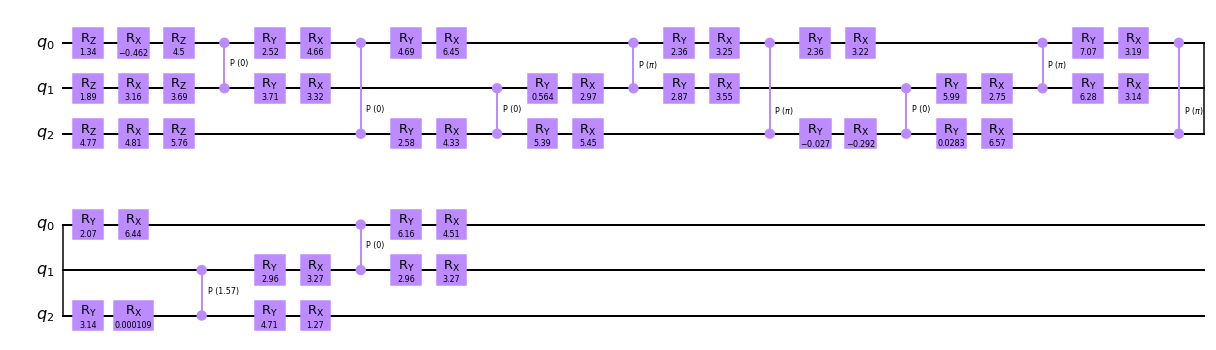

In [11]:
with open('data/toff3_connected_successful_results.pickle', 'rb') as f:
    peek = pickle.load(f)
    
peek[2][1].draw(output='mpl')

## Constrained connectivity

In [25]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(chain_layer(3), 14))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 8,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 10
num_batches = 5

cp_decompose_smart(u_toff3, 
                   anz,
                   regularization_options=reg_options,
                   num_samples=num_samples, 
                   key=key,
                   disc_func=disc2,
                   cp_dist='0',
                   save_to='toff3_chain',
                   num_batches=num_batches,
                   r_increment=0.2,
                   disc_equlibrium=0.2)

batch 1 out of 5
r is 0.001

Computing raw results.


100%|██████████| 10/10 [00:25<00:00,  2.52s/it]



Selecting prospective results:


10it [00:00, 96.60it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]
batch 2 out of 5
r is 0.0008

Computing raw results.


100%|██████████| 10/10 [00:24<00:00,  2.48s/it]



Selecting prospective results:


10it [00:00, 83.88it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:08<00:00,  8.84s/it]


1 successful.
cz counts are:
[8]
batch 3 out of 5
r is 0.00096

Computing raw results.


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]



Selecting prospective results:


10it [00:00, 66.21it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:08<00:00,  8.53s/it]


1 successful.
cz counts are:
[8]
batch 4 out of 5
r is 0.001152

Computing raw results.


100%|██████████| 10/10 [00:23<00:00,  2.39s/it]



Selecting prospective results:


10it [00:00, 72.38it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]
batch 5 out of 5
r is 0.0009216000000000001

Computing raw results.


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]



Selecting prospective results:


10it [00:00, 59.02it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:08<00:00,  8.28s/it]

1 successful.
cz counts are:
[8]


## Up to SWAPs

In [27]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(sequ_layer(3), 10))

reg_options = {'r': 0.01,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 6,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(30)
num_samples = 50

successful_results, failed_results = decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2_swap,
                                               )


Computing raw results.


100%|██████████| 50/50 [01:35<00:00,  1.91s/it]



Selecting prospective results:


50it [00:00, 102.08it/s]


9 found.

Verifying prospective results:


100%|██████████| 9/9 [01:33<00:00, 10.36s/it]

8 sucessfull.
cz counts are:
[6, 6, 6, 6, 6, 6, 6, 6]


In [28]:
for sr in successful_results:
    cz, circ, u, angs = sr
    print(disc2(u(angs), u_toff3))

3.5762787e-07
7.1525574e-07
4.7683716e-07
2.3841858e-07
9.536743e-07
7.1525574e-07
9.536743e-07
7.1525574e-07


DeviceArray(3.0941035e-07, dtype=float32)

## Unconstrained CP

Learning 3-qubits Toffoli with predefined pattern of 2-qubit gates. Note that the problem is not trivial because without CP gates the learning is about 80% likely to be stuck in local minimum. Let's see if we can do better with CP regularization.

First, unconctrained CP optimization gets the job done very easily and reliably.

In [ ]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
anz_toff3 = Ansatz(3, 'cp', placements={'free': placements_toff3})

anz_toff3.circuit().draw(output='mpl')

In [ ]:
%time
res, best_angles, sucess = anz_toff3.learn(u_toff3)
_,_ = report_cp_learning(res)

## CP learning vs random learning.

When regularization parameter $r$ is large, all cp angles fall into immediate local minimums. This correspond to random choice of CZ locations in the circuit. It is necessary to compare out approach to this simplistic one.

In [8]:
with open('data/toff3_connected_raw_results.pickle', 'rb') as f:
    raw_results = pickle.load(f)

In [7]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(sequ_layer(3), 10))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 7,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 50

successful_results, failed_results = cp_decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='uniform',
                                               save_raw_results=True,
                                               save_successful_results=False,
                                               save_to='toff3_connected')


Computing raw results.


100%|██████████| 50/50 [01:35<00:00,  1.91s/it]



Selecting prospective results:


50it [00:00, 84.64it/s]


19 found.

Verifying prospective results:


100%|██████████| 19/19 [03:29<00:00, 11.05s/it]

18 successful.
cz counts are:
[7, 6, 6, 6, 7, 7, 6, 7, 7, 6, 6, 6, 6, 6, 6, 7, 6, 7]


In [81]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(sequ_layer(3), 10))

reg_options = {'r': 1,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 7,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 50

successful_results, failed_results = cp_decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='uniform',
                                               save_raw_results=True,
                                               save_successful_results=False,
                                               save_to='toff3_connected')


Computing raw results.


100%|██████████| 50/50 [01:31<00:00,  1.84s/it]



Selecting prospective results:


50it [00:00, 106.98it/s]


2 found.

Verifying prospective results:


100%|██████████| 2/2 [00:22<00:00, 11.14s/it]

2 successful.
cz counts are:
[7, 7]


In [82]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(chain_layer(3), 15))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 9,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 50

successful_results, failed_results = cp_decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='uniform',
                                               save_raw_results=True,
                                               save_successful_results=False,
                                               save_to='toff3_chain')


Computing raw results.


100%|██████████| 50/50 [01:39<00:00,  1.99s/it]



Selecting prospective results:


50it [00:00, 56.24it/s]


29 found.

Verifying prospective results:


100%|██████████| 29/29 [05:04<00:00, 10.49s/it]

27 successful.
cz counts are:
[8, 8, 9, 8, 8, 9, 8, 9, 8, 9, 9, 8, 9, 8, 9, 9, 9, 8, 9, 8, 8, 9, 9, 9, 9, 9, 8]


In [84]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(chain_layer(3), 15))

reg_options = {'r': 1,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 9,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 50

successful_results, failed_results = cp_decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='uniform',
                                               save_raw_results=True,
                                               save_successful_results=False,
                                               save_to='toff3_chain')


Computing raw results.


100%|██████████| 50/50 [01:53<00:00,  2.27s/it]



Selecting prospective results:


50it [00:00, 58.32it/s]


4 found.

Verifying prospective results:


100%|██████████| 4/4 [00:48<00:00, 12.20s/it]

4 successful.
cz counts are:
[9, 9, 9, 9]


In [85]:
with open('data/toff3_chain_raw_results.pickle', 'rb') as f:
    raw_results = pickle.load(f)

cz count: 7
fidelity at this count: 0.14658695459365845


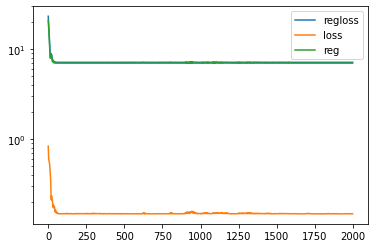

In [113]:
_ = report_cp_learning(raw_results[27], anz.cp_mask)

# Toffoli 4

In [3]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data


anz = Ansatz(4, 'cp', fill_layers(sequ_layer(4), 18))

reg_options = {'r': 0.008,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 18,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(13)

num_samples = 100
num_batches = 10

cp_decompose_smart(u_toff4, 
                   anz,
                   regularization_options=reg_options,
                   num_samples=num_samples, 
                   key=key,
                   disc_func=disc2,
                   cp_dist='uniform',
                   save_to='toff4_connected',
                   num_batches=num_batches,
                   r_increment=0.2,
                   disc_equlibrium=0.1)


Batch 1 out of 10
r is 0.008

Computing raw results.


100%|██████████| 100/100 [03:23<00:00,  2.03s/it]



Selecting prospective results:


100it [00:01, 52.28it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:21<00:00, 21.80s/it]


1 successful.
cz counts are:
[16]

Batch 2 out of 10
r is 0.0064

Computing raw results.


100%|██████████| 100/100 [03:36<00:00,  2.17s/it]



Selecting prospective results:


100it [00:01, 55.31it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:22<00:00, 22.18s/it]


1 successful.
cz counts are:
[18]

Batch 3 out of 10
r is 0.00512

Computing raw results.


100%|██████████| 100/100 [03:18<00:00,  1.98s/it]



Selecting prospective results:


100it [00:01, 57.68it/s]


4 found.

Verifying prospective results:


100%|██████████| 4/4 [01:23<00:00, 20.87s/it]


4 successful.
cz counts are:
[18, 18, 17, 17]

Batch 4 out of 10
r is 0.006144

Computing raw results.


100%|██████████| 100/100 [03:18<00:00,  1.98s/it]



Selecting prospective results:


100it [00:01, 56.77it/s]


2 found.

Verifying prospective results:


100%|██████████| 2/2 [00:40<00:00, 20.31s/it]


2 successful.
cz counts are:
[18, 18]

Batch 5 out of 10
r is 0.004915200000000001

Computing raw results.


 18%|█▊        | 18/100 [00:54<04:08,  3.03s/it]


KeyboardInterrupt: 

In [38]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data


anz = Ansatz(4, 'cp', fill_layers(sequ_layer(4), 25))

reg_options = {'r': 0.01,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 35,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(12)

num_samples = 100
num_batches = 20

cp_decompose_smart(u_toff4, 
                   anz,
                   regularization_options=reg_options,
                   num_samples=num_samples, 
                   key=key,
                   disc_func=disc2,
                   cp_dist='uniform',
                   save_to='toff4_connected',
                   num_batches=num_batches,
                   r_increment=0.0,
                   disc_equlibrium=0.1)


Batch 1 out of 20
r is 0.01

Computing raw results.


100%|██████████| 100/100 [03:48<00:00,  2.28s/it]



Selecting prospective results:


100it [00:02, 34.45it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:34<00:00, 34.81s/it]


1 successful.
cz counts are:
[18]

Batch 2 out of 20
r is 0.01

Computing raw results.


100%|██████████| 100/100 [03:37<00:00,  2.18s/it]



Selecting prospective results:


100it [00:02, 42.06it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

Batch 3 out of 20
r is 0.01

Computing raw results.


  0%|          | 0/100 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [2]:
with open('data/toff4_connected_raw_results.pickle', 'rb') as f:
    raw_results = pickle.load(f)

In [14]:
scatter_data = [[cz, disc] for cz, disc, _ in [evaluate_cp_result(r, anz.cp_mask) for r in raw_results]]

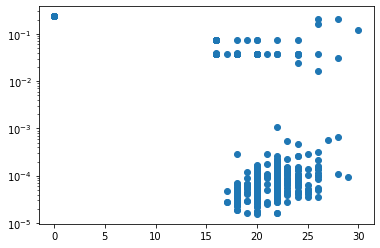

In [17]:
plt.scatter([cz for cz,_ in scatter_data], [disc for _, disc in scatter_data])
plt.yscale('log')

In [81]:
raw_results[0]

{'params': array([[ 4.125892  ,  5.1388254 ,  2.7351167 , ...,  3.9983227 ,
          0.24633169, -0.09999567],
        [ 4.051372  ,  5.058698  ,  2.8124666 , ...,  3.9227188 ,
          0.3261888 , -0.02741227],
        [ 3.9740071 ,  5.1145015 ,  2.8040562 , ...,  3.9722896 ,
          0.265896  ,  0.04432033],
        ...,
        [ 4.3496184 ,  6.043369  ,  3.9367669 , ...,  3.1512654 ,
         -0.03149092,  0.7677141 ],
        [ 4.3492355 ,  6.0394473 ,  3.9369016 , ...,  3.1540208 ,
         -0.03699383,  0.7680267 ],
        [ 4.350139  ,  6.0435696 ,  3.9368849 , ...,  3.1517267 ,
         -0.03236842,  0.76731783]], dtype=float32),
 'regloss': array([0.99977046, 0.9654914 , 0.5663462 , ..., 0.00851124, 0.008405  ,
        0.00818359], dtype=float32),
 'loss': array([9.6467221e-01, 5.6557012e-01, 4.2080861e-01, ..., 8.6158514e-04,
        6.4778328e-04, 3.9452314e-04], dtype=float32),
 'reg': array([0.00081922, 0.00077602, 0.00094527, ..., 0.00754353, 0.00753581,
        0.0

cz count: 18
fidelity at this count: 0.038098156452178955


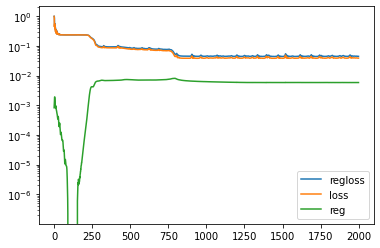

In [80]:
_,_ = report_cp_learning(raw_results[33], anz.cp_mask)

In [40]:
cz, circ, u, angs = successful_results[1]
circ(angs).draw(output='mpl')

## Restricted topology

In [29]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data


anz = Ansatz(4, 'cp', fill_layers(chain_layer(4), 35))

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 23,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(7)
num_samples = 1000

successful_results, failed_results = decompose(u_toff4, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key
                                               )


Computing raw results.


100%|██████████| 1000/1000 [30:15<00:00,  1.82s/it]



Selecting prospective results:


1000it [00:27, 36.64it/s]


15 found.

Verifying prospective results:


100%|██████████| 15/15 [04:28<00:00, 17.87s/it]

13 sucessfull.
cz counts are:
[22, 22, 23, 22, 21, 19, 23, 23, 22, 22, 22, 23, 19]


In [13]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

reg_options = {'r': 0.001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 20,
               'angle_tolerance': 0.2,
               }

key = random.PRNGKey(7)
num_samples = 500
num_batches = 4
layer = chain_layer(4)
initial_num_gates = 35

cp_decompose_adaptive(u_toff4, 
                      layer,
                      initial_num_gates=initial_num_gates,
                      regularization_options=reg_options,
                      num_samples=num_samples, 
                      num_batches=num_batches,
                      key=key,
                      disc_func=disc2,
                      cp_dist='uniform',
                      save_to='toff4_chain')


Batch 1 out of 4
r: 0.001, num_gates: 35

Computing raw results.


100%|██████████| 500/500 [15:25<00:00,  1.85s/it]



Selecting prospective results:


500it [00:13, 36.00it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 27.102941176470587, total successful: 68

Batch 2 out of 4
r: 0.001, num_gates: 36

Computing raw results.


100%|██████████| 500/500 [15:24<00:00,  1.85s/it]



Selecting prospective results:


500it [00:14, 34.64it/s]


2 found.

Verifying prospective results:


100%|██████████| 2/2 [00:32<00:00, 16.33s/it]


2 successful.
cz counts are:
[20, 20]

 mean cz count: 27.728571428571428, total successful: 70

Batch 3 out of 4
r: 0.0011, num_gates: 36

Computing raw results.


100%|██████████| 500/500 [15:20<00:00,  1.84s/it]



Selecting prospective results:


500it [00:14, 35.37it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:16<00:00, 16.17s/it]


1 successful.
cz counts are:
[19]

 mean cz count: 27.484375, total successful: 64

Batch 4 out of 4
r: 0.0011, num_gates: 37

Computing raw results.


100%|██████████| 500/500 [16:02<00:00,  1.93s/it]



Selecting prospective results:


500it [00:14, 34.45it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:18<00:00, 18.62s/it]


1 successful.
cz counts are:
[19]

 mean cz count: 27.96, total successful: 75


In [4]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

reg_options = {'r': 0.0012,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 20,
               'angle_tolerance': 0.2,
               }

key = random.PRNGKey(7)
num_samples = 500
num_batches = 6
layer = chain_layer(4)
initial_num_gates = 40

cp_decompose_adaptive(u_toff4, 
                      layer,
                      initial_num_gates=initial_num_gates,
                      regularization_options=reg_options,
                      num_samples=num_samples, 
                      num_batches=num_batches,
                      key=key,
                      disc_func=disc2,
                      cp_dist='uniform',
                      save_to='toff4_chain')


Batch 1 out of 6
r: 0.0012, num_gates: 40

Computing raw results.


100%|██████████| 500/500 [16:01<00:00,  1.92s/it]



Selecting prospective results:


500it [00:15, 31.32it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 28.60952380952381, total successful: 105

Batch 2 out of 6
r: 0.0012, num_gates: 41

Computing raw results.


100%|██████████| 500/500 [15:52<00:00,  1.91s/it]



Selecting prospective results:


500it [00:16, 30.68it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:20<00:00, 20.28s/it]


1 successful.
cz counts are:
[20]

 mean cz count: 29.161538461538463, total successful: 130

Batch 3 out of 6
r: 0.00132, num_gates: 41

Computing raw results.


100%|██████████| 500/500 [15:49<00:00,  1.90s/it]



Selecting prospective results:


500it [00:16, 30.37it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 28.296296296296298, total successful: 108

Batch 4 out of 6
r: 0.00132, num_gates: 42

Computing raw results.


100%|██████████| 500/500 [15:30<00:00,  1.86s/it]



Selecting prospective results:


500it [00:16, 30.27it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:18<00:00, 18.24s/it]


1 successful.
cz counts are:
[19]

 mean cz count: 29.449664429530202, total successful: 149

Batch 5 out of 6
r: 0.0014520000000000002, num_gates: 42

Computing raw results.


100%|██████████| 500/500 [15:34<00:00,  1.87s/it]



Selecting prospective results:


500it [00:16, 31.00it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:17<00:00, 17.23s/it]


1 successful.
cz counts are:
[20]

 mean cz count: 28.8705035971223, total successful: 139

Batch 6 out of 6
r: 0.0014520000000000002, num_gates: 43

Computing raw results.


100%|██████████| 500/500 [15:59<00:00,  1.92s/it]



Selecting prospective results:


500it [00:17, 28.28it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 29.32191780821918, total successful: 146


In [4]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

reg_options = {'r': 0.0015,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 20,
               'angle_tolerance': 0.2,
               }

key = random.PRNGKey(7)
num_samples = 500
num_batches = 6
layer = chain_layer(4)
initial_num_gates = 35

cp_decompose_adaptive(u_toff4, 
                      layer,
                      initial_num_gates=initial_num_gates,
                      regularization_options=reg_options,
                      num_samples=num_samples, 
                      num_batches=num_batches,
                      key=key,
                      disc_func=disc2,
                      cp_dist='uniform',
                      save_to='toff4_chain')


Batch 1 out of 6
r: 0.0015, num_gates: 35

Computing raw results.


100%|██████████| 500/500 [15:44<00:00,  1.89s/it]



Selecting prospective results:


500it [00:14, 35.34it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 26.977272727272727, total successful: 44

Batch 2 out of 6
r: 0.0015, num_gates: 36

Computing raw results.


100%|██████████| 500/500 [15:29<00:00,  1.86s/it]



Selecting prospective results:


500it [00:14, 33.88it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 27.333333333333332, total successful: 60

Batch 3 out of 6
r: 0.0016500000000000002, num_gates: 36

Computing raw results.


100%|██████████| 500/500 [15:40<00:00,  1.88s/it]



Selecting prospective results:


500it [00:14, 34.87it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 27.357142857142858, total successful: 42

Batch 4 out of 6
r: 0.0018150000000000004, num_gates: 37

Computing raw results.


 57%|█████▋    | 287/500 [09:25<06:59,  1.97s/it]


KeyboardInterrupt: 

In [32]:
cz, circ, u, angs = successful_results[-1]
disc2(u(angs), u_toff4)

DeviceArray(8.34465e-07, dtype=float32)

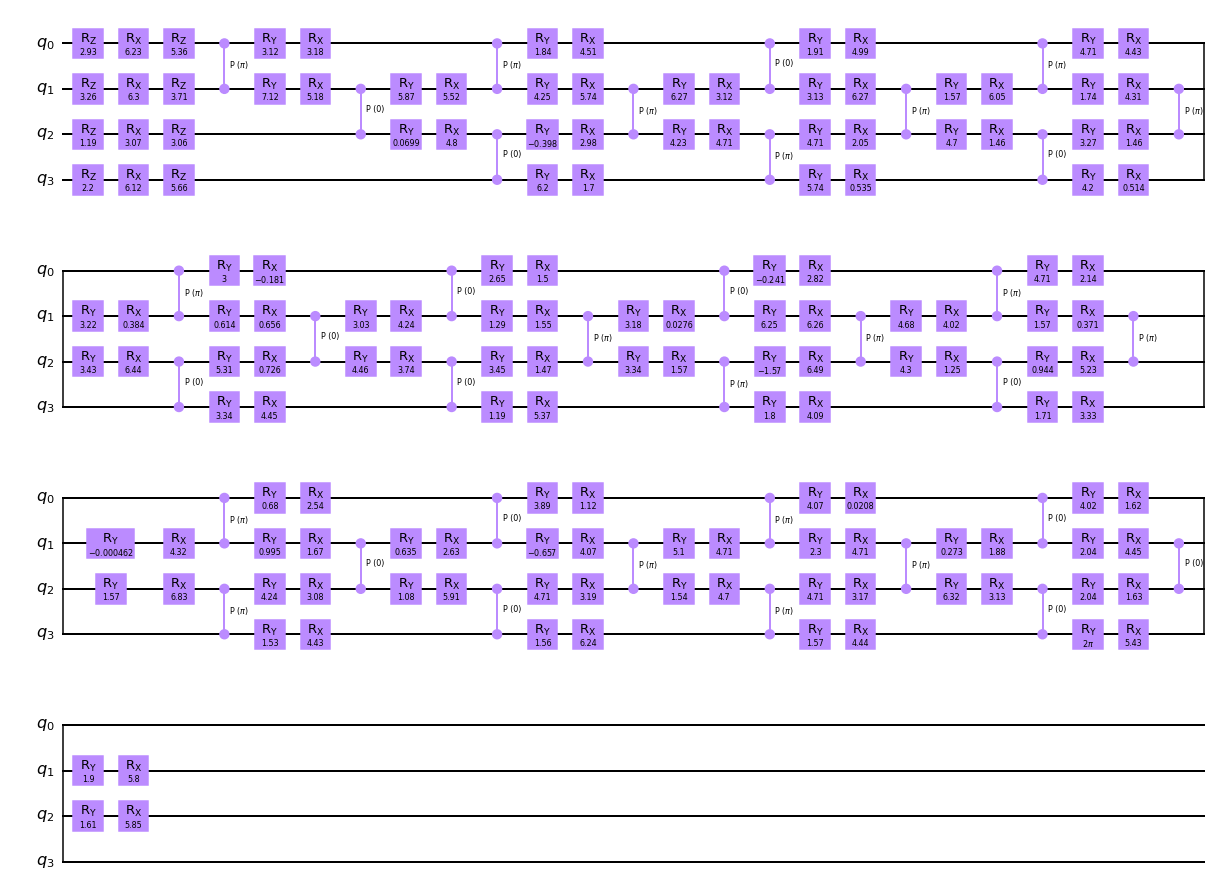

In [31]:
circ(angs).draw(output='mpl')

In [17]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data


anz = Ansatz(4, 'cp', fill_layers(sequ_layer(4), 26))
                                  

reg_options = {'r': 0.002,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 16,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(135)
num_samples = 300

successful_results, failed_results = decompose(u_toff4, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               cp_dist='0'
                                               )


Computing raw results.


100%|██████████| 300/300 [12:19<00:00,  2.46s/it]



Selecting prospective results:


300it [00:05, 53.81it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]

0 sucessfull.
cz counts are:
[]


# Toffoli 5

## Connected

In [32]:
qc = QuantumCircuit(5)
qc.mct([0, 1, 2, 3], 4)
u_toff5 = Operator(qc.reverse_bits()).data

reg_options = {'r': 0.0001,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'num_gates': 75,
               }

key = random.PRNGKey(1)
num_samples = 200
num_batches = 5

layer = chain_layer(5)
initial_num_gates = 90

cp_decompose_adaptive(u_toff5, 
                      layer,
                      initial_num_gates=initial_num_gates,
                      regularization_options=reg_options,
                      num_samples=num_samples, 
                      num_batches=num_batches,
                      key=key,
                      disc_func=disc2,
                      cp_dist='uniform',
                      save_to='toff5_conn')


Batch 1 out of 5
r: 0.0001, num_gates: 90

Computing raw results.


100%|██████████| 200/200 [19:09<00:00,  5.75s/it]



Selecting prospective results:


200it [00:14, 13.84it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 94.0, total successful: 2

Batch 2 out of 5
r: 0.0001, num_gates: 91

Computing raw results.


100%|██████████| 200/200 [25:07<00:00,  7.54s/it]  



Selecting prospective results:


200it [00:14, 13.52it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 103.0, total successful: 1

Batch 3 out of 5
r: 0.00011000000000000002, num_gates: 92

Computing raw results.


100%|██████████| 200/200 [19:31<00:00,  5.86s/it]



Selecting prospective results:


200it [00:13, 14.36it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 99.0, total successful: 1

Batch 4 out of 5
r: 0.00011000000000000002, num_gates: 92

Computing raw results.


100%|██████████| 200/200 [19:19<00:00,  5.80s/it]



Selecting prospective results:


200it [00:17, 11.29it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 0, total successful: 0

Batch 5 out of 5
r: 0.00011000000000000002, num_gates: 93

Computing raw results.


100%|██████████| 200/200 [20:02<00:00,  6.01s/it]



Selecting prospective results:


200it [00:14, 14.26it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]


0 successful.
cz counts are:
[]

 mean cz count: 0, total successful: 0


# Learning in the difficult region

In [53]:
%%time
placements = fill_layers(sequ_layer(3), 9)
anz_cz = Ansatz(3, 'cz', placements=placements)
target_angles = random_angles(anz_cz.num_angles, key=random.PRNGKey(1))
u_target = anz_cz.unitary(target_angles)

anz_cp = Ansatz(3, 'cp', placements=placements)
angles_hist, loss_hist, disc_hist, penalty_hist = anz_cp.learn(u_target, 
                                      method='natural adam', 
                                      cp_penalty=True, 
                                      h=2, 
                                      t=0.15)

best_angles = angles_hist[jnp.argmin(loss_hist)]

CPU times: user 47.4 s, sys: 19 s, total: 1min 6s
Wall time: 29.6 s


14.0


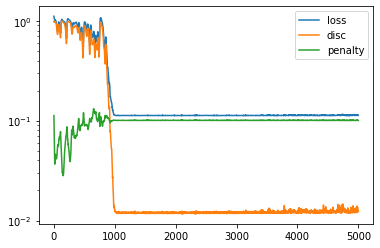

In [54]:
print(count_cnots(best_angles*anz_cp.cp_mask))
plt.plot(loss_hist, label='loss')
plt.plot(disc_hist, label='disc')
plt.plot(penalty_hist, label='penalty')
plt.yscale('log')
plt.legend()

In [55]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 9, 'natural adam', t=t, num_samples=100)

CPU times: user 38min 25s, sys: 6min 54s, total: 45min 20s
Wall time: 31min 38s


In [56]:
sum(success_hist)/len(success_hist)

0.0

In [58]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 9, 'natural gd', t=t, num_samples=100)

CPU times: user 38min 50s, sys: 5min 53s, total: 44min 44s
Wall time: 32min 43s


In [59]:
sum(success_hist)/len(success_hist)

0.0

In [60]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 9, 'adam', t=t, num_samples=100)

CPU times: user 16min 51s, sys: 7.4 s, total: 16min 58s
Wall time: 16min 34s


In [61]:
sum(success_hist)/len(success_hist)

0.0

In [5]:
%%time
placements = fill_layers(sequ_layer(3), 8)
anz_cz = Ansatz(3, 'cz', placements=placements)
target_angles = random_angles(anz_cz.num_angles, key=random.PRNGKey(1))
u_target = anz_cz.unitary(target_angles)

t=0.15
anz_cp = Ansatz(3, 'cp', placements=fill_layers(sequ_layer(3), 10))

CPU times: user 841 ms, sys: 5.87 ms, total: 846 ms
Wall time: 835 ms


In [6]:
%%time
best_angles_hist, success_hist = success_rate(anz_cp, u_target, 10, 'adam', t=t, num_samples=50)

CPU times: user 9min 5s, sys: 3.9 s, total: 9min 9s
Wall time: 8min 56s


In [7]:
sum(success_hist)

0

Not successfull yet.

# Learning with extra gates

Works fine for toffoli 3.

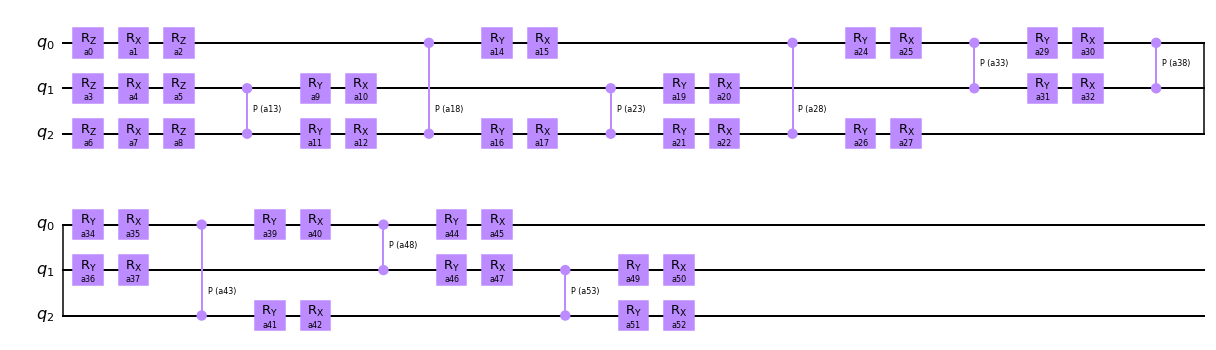

In [8]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
extra_placements = [[0, 2], [0, 1], [1, 2]]

anz_toff3 = Ansatz(3, 'cp', placements={'free': placements_toff3+extra_placements})

anz_toff3.circuit().draw(output='mpl')

In [83]:
%%time
initial_angles = random_cp_angles(anz_toff3.num_angles, anz_toff3.cp_mask, key=random.PRNGKey(10))
res = anz_toff3.learn(u_toff3, method='natural adam', cp_penalty=True, t=0.15, learning_rate=0.025, r=0.0005, initial_params=initial_angles)
angs_hist, loss_hist, disc_hist, penalty_hist = res

CPU times: user 1min 1s, sys: 21.1 s, total: 1min 22s
Wall time: 41.6 s


cnot count: 6.0
fidelity at this count: 8.821487426757812e-06


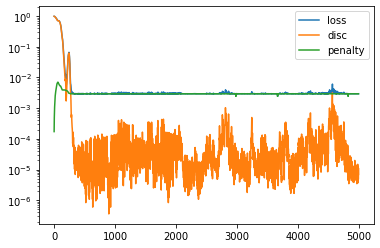

In [84]:
best_angles, best_cp_angles = report_cp_learning(res, cp_mask=anz_toff3.cp_mask)

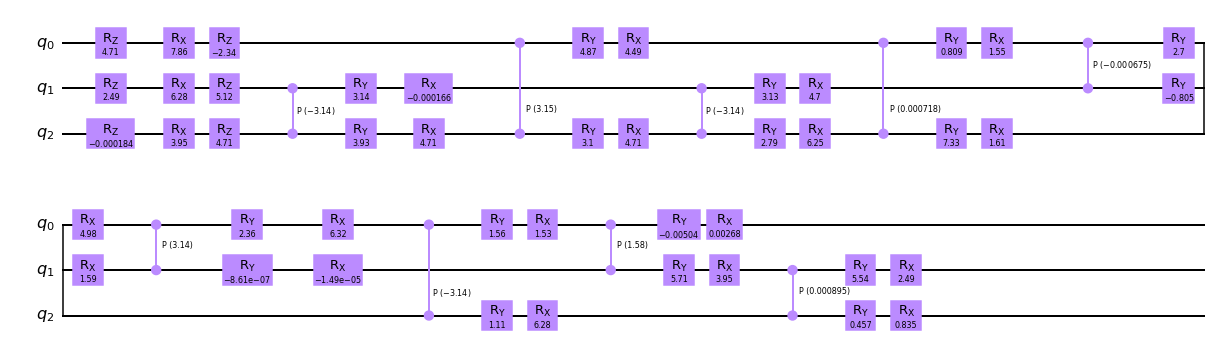

In [68]:
anz_toff3.circuit(best_angles).draw(output='mpl')

In [3]:
anz_cz = Ansatz(3, 'cz', placements=fill_layers(sequ_layer(3), 8))
angles_target = random_angles(anz_cz.num_angles, key=random.PRNGKey(123))
u_target = anz_cz.unitary(angles_target)

anz_cp = Ansatz(3, 'cp', placements=fill_layers(sequ_layer(3), 14))

cnot count: 18.0
fidelity at this count: 0.005213022232055664
CPU times: user 17.4 s, sys: 346 ms, total: 17.8 s
Wall time: 16.3 s


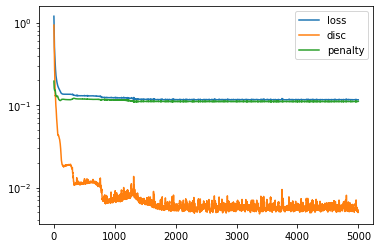

In [43]:
%%time
initial_angles = random_cp_angles(anz_cp.num_angles, anz_cp.cp_mask, key=random.PRNGKey(2))
initial_angles = initial_angles+jnp.pi*jnp.ones(len(initial_angles))*anz_cp.cp_mask
initial_angles = random_angles(anz_cp.num_angles, key=random.PRNGKey(2))

res = anz_cp.learn(u_target, 
                   method='adam', 
                   cp_penalty=True, 
                   xmax=1.5, 
                   ymax=2,
                   plato=0.01,
                   learning_rate=0.1, 
                   r=0.01, 
                   initial_params=initial_angles, 
                   num_iterations=5000)

angs_hist, loss_hist, disc_hist, penalty_hist = res
best_angles, best_cp_angles = report_cp_learning(res, cp_mask=anz_cp.cp_mask)

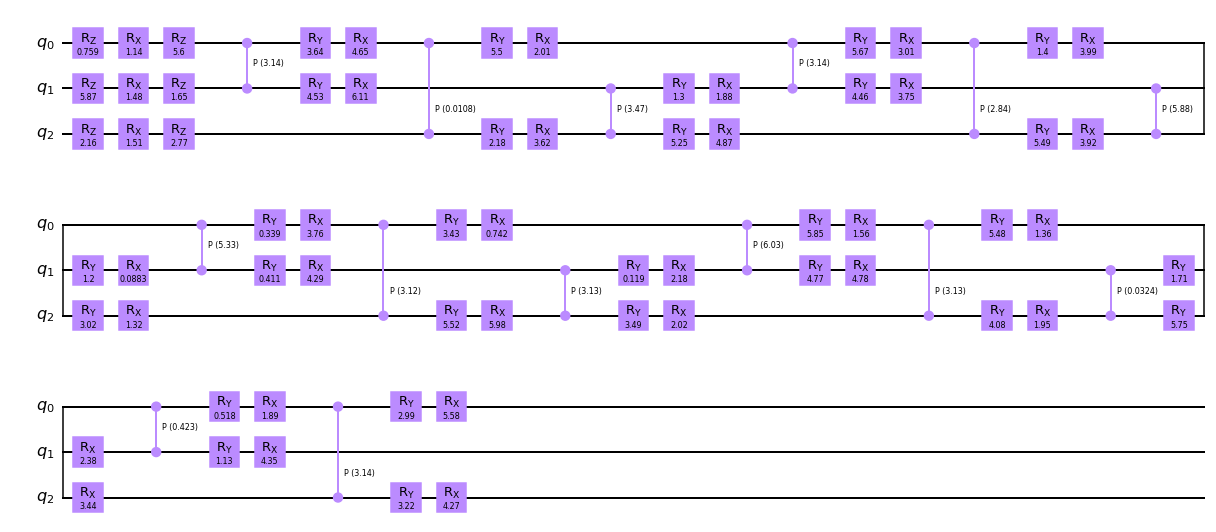

In [44]:
anz_cp.circuit(best_angles % (2*jnp.pi)).draw(output='mpl')

In [45]:
anz_3 = Ansatz(3, 'cz', placements=fill_layers(sequ_layer(3), 10))
ah, lh = anz_3.learn(u_target)

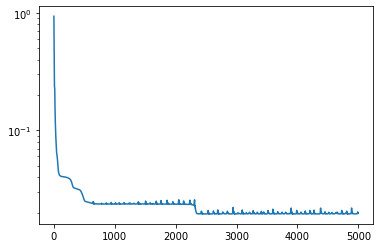

In [38]:
plt.plot(lh)
plt.yscale('log')

# CP circuits learn themselves

Small-scale experiments below suggest that CP circuits are less prone to getting stuck in local minima than CZ circuits of the same gate count. The experiments are for randomly initialized CP angles so the 'effective cz count' of the circuit may be lower than of the corresponding CZ circuits. This will be tested later.

In [22]:
%%time 
key = random.PRNGKey(134)
num_qubits = 3 
num_repeats = 10

gate_counts = list(range(15))[::2]
success_rates = []
for num_gates in gate_counts:
    anz = Ansatz(num_qubits, 'cp', placements=fill_layers(sequ_layer(num_qubits), num_gates))
    key, subkey = random.split(key)
    target_angles = random_angles(anz.num_angles, key=subkey)
    target_u = anz.unitary(target_angles)
    ah, lh, sh = unitary_learn_repeat(anz.unitary, 
                                  target_u, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1,
                                  num_repeats=num_repeats,
                                  target_loss=1e-4)
    
    success_rates.append(sum(sh)/len(sh))

with open('success_rates_3cp.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 9min 36s, sys: 9.35 s, total: 9min 45s
Wall time: 9min 14s


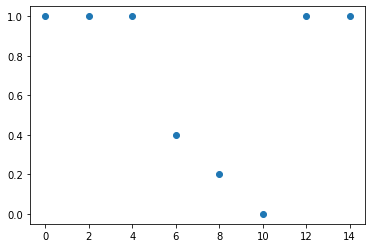

In [23]:
with open('success_rates_3cp.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(gate_counts, success_rates)

Let's look at a difficult point in the middle region.

In [25]:
%%time 
key = random.PRNGKey(134)
num_qubits = 3 
num_repeats = 50
num_gates = 9

anz = Ansatz(num_qubits, 'cp', placements=fill_layers(sequ_layer(num_qubits), num_gates))
key, subkey = random.split(key)
target_angles = random_angles(anz.num_angles, key=subkey)
target_u = anz.unitary(target_angles)
ah, lh, sh = unitary_learn_repeat(anz.unitary, 
                                  target_u, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1,
                                  num_repeats=num_repeats,
                                  target_loss=1e-4)
print(sum(sh)/len(sh))    

0.02
CPU times: user 9min 10s, sys: 15 s, total: 9min 25s
Wall time: 8min 32s


Now let us make a different comparison -- instead of learning CP circuits with random values of CP-angles we will fix all CP gates to be CZ gates in the target circuits. This will give a more honest comparison with the difficulty of learning with CZ circuits.

In [32]:
%%time 
key = random.PRNGKey(134)
num_qubits = 3 
num_repeats = 10

gate_counts = list(range(15))[::2]
success_rates = []
for num_gates in gate_counts:
    anz = Ansatz(num_qubits, 'cp', placements=fill_layers(sequ_layer(num_qubits), num_gates))
    key, subkey = random.split(key)
    target_angles = random_cp_angles(anz.num_angles, anz.cp_mask, key=subkey)+jnp.pi*jnp.ones(anz.num_angles)*anz.cp_mask
    target_u = anz.unitary(target_angles)
    ah, lh, sh = unitary_learn_repeat(anz.unitary, 
                                  target_u, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1,
                                  num_repeats=num_repeats,
                                  target_loss=1e-4)
    
    success_rates.append(sum(sh)/len(sh))

with open('success_rates_3cp_cz.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 10min 33s, sys: 11.6 s, total: 10min 45s
Wall time: 10min 15s


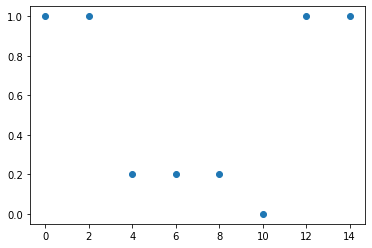

In [33]:
with open('success_rates_3cp_cz.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(gate_counts, success_rates)

Again, let's look at the middle region.

In [34]:
%%time 
key = random.PRNGKey(134)
num_qubits = 3 
num_repeats = 50
num_gates = 9

anz = Ansatz(num_qubits, 'cp', placements=fill_layers(sequ_layer(num_qubits), num_gates))
key, subkey = random.split(key)
target_angles = random_cp_angles(anz.num_angles, anz.cp_mask, key=subkey)+jnp.pi*jnp.ones(anz.num_angles)*anz.cp_mask
target_u = anz.unitary(target_angles)
ah, lh, sh = unitary_learn_repeat(anz.unitary, 
                                  target_u, 
                                  anz.num_angles, 
                                  'adam', 
                                  0.1,
                                  num_repeats=num_repeats,
                                  target_loss=1e-4)
print(sum(sh)/len(sh))    

0.0
CPU times: user 9min 44s, sys: 15.5 s, total: 10min
Wall time: 9min 7s


It appears that CP gates do not significantly improve the chance of escaping the local minima even for 3-qubit gates.